# Analysis of Kaggle's Heart Failure dataset

Required libraries for data wrangling, statistical analysis and plotting. ~~Plotnine was chosen for similarity to ggplot2 in R.~~ As Plotnine does not have a pairplot API for fast pairwise comparison, I'll switch to Seaborn.

In [1239]:
import pandas as pd
import seaborn as sb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#from pytorch_tabular import TabularModel
#from pytorch_tabular.models import CategoryEmbeddingModelConfig
#from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

## Data loading, inspection and curation
First, load the heart failure dataset supplied by Kaggle and perform some basic introspection on the overall shape of the data and the type of features it contains.

In [1240]:
df = pd.read_csv('heart.csv')
print(df.shape)
print(df.dtypes)
df.head()
#sb.pairplot(df, hue="HeartDisease", corner=True)

(918, 12)
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


This learns us that there are a total of 918 rows and 12 features. Several features have object datatype, but I would prefer category datatype. So for those features I'll check whether the number of distinct objects per feature is small. HeartDisease could be transformed to a boolean, perhaps ExerciseAngina nad FastingBS as well.

In [1241]:
for col in df[["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina"]]:
    print(col, df[col].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS [0 1]
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']


Above suspicions are confirmed; the respective features have few distinct values each and some can be turned to a boolean. Below the colums are assigned their new data types and a check is done afterwards to assure the conversion was done correctly, such that every feature retains all of its values.

In [1242]:
# Convert to category
#for col in df[["Sex","ChestPainType","RestingECG"]]:
#    df[col] = df[col].astype('category')
# Convert to boolean
#for col in df[["FastingBS","HeartDisease"]]:
#    df[col] = df[col].astype('bool')
df["HeartDisease"] = df["HeartDisease"].astype('bool')
#df["ExerciseAngina"] = df['ExerciseAngina'].replace({'N': 0, 'Y': 1})
#df["ExerciseAngina"] = df["ExerciseAngina"].astype('bool')
print(df.dtypes)
for col in df[["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","HeartDisease"]]:
    print(col, df[col].unique())

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease         bool
dtype: object
Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS [0 1]
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
HeartDisease [False  True]


## Explorative analysis

There are a variety of interesting feature combinations for an initial explorative analysis, to give some insight on general feature value distributions and correlations.

In [1243]:
# Add binned 5y range age for later
# cut_bins = []
# cut_labels = []
# for i in range(0,20):
#     cut_bins.append(i*5)
#     cut_labels.append(str((i*5)-5)+"-"+str(i*5))
# cut_labels.remove("-5-0") # nr of labels should be bins-1
# df["Bin_Age"] = pd.cut(df["Age"], bins=cut_bins, labels=cut_labels)
# df["Bin_Age"] = df["Bin_Age"].astype("category")

# Distribution of HD per Sex, as counts and percentage of total nr of people
df_dist = (
    df.groupby('Sex', as_index=True)
        .agg(HeartDisease=('HeartDisease', 'sum'),
             Nr_of_people=('HeartDisease', 'count'),
             HD_pct=('HeartDisease', 'mean'))
)
df_dist["HD_pct"] *= 100
print(df_dist)

     HeartDisease  Nr_of_people     HD_pct
Sex                                       
F              50           193  25.906736
M             458           725  63.172414


--

C:\Users\tch\AppData\Local\Temp/ipykernel_8124/421412216.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


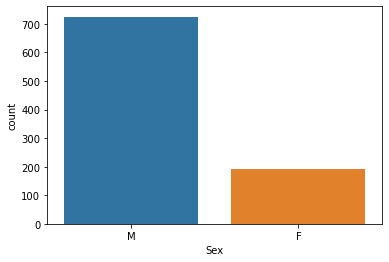

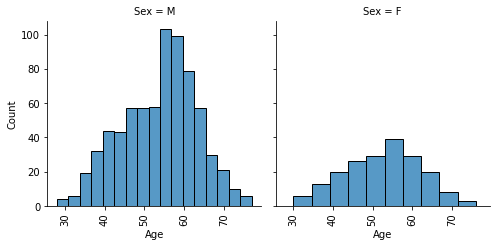

In [1244]:
# Count Male vs Female
sb.countplot(x="Sex",data=df)

# Plot distribution of Male/Female to Age, with median age
g = sb.FacetGrid(df, col="Sex", height=3.5, aspect=1)
g.map(sb.histplot, "Age")
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

--

In [1245]:
# sb.pairplot(df, hue="HeartDisease", corner=True,
# vars = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"],
# plot_kws={"alpha":0.4})


In [1246]:
# df_m = df.loc[df["Sex"] == "M"]
# df_f = df.loc[df["Sex"] == "F"]
# for df_x in [df_m,df_f]:
#     sb.pairplot(df_x, hue="HeartDisease", corner=True,
#     vars = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"],
#     plot_kws={"alpha":0.4})

### Simple binary classification NN

In [1247]:
# Label encoding
le = LabelEncoder()
for lab in ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]:
    df[lab] = le.fit_transform(df[lab])
print(df.dtypes)

Age                 int64
Sex                 int32
ChestPainType       int32
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int32
MaxHR               int64
ExerciseAngina      int32
Oldpeak           float64
ST_Slope            int32
HeartDisease         bool
dtype: object


In [1248]:
# Define input/output
X = df.iloc[:, 0:-1] # All features minus HeartDisease
y = df.iloc[:, -1] # HeartDisease

# Define train/test sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

# Standardization input feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Parameters of the model
torch.manual_seed(0)
EPOCHS = 6
BATCH_SIZE = 512
LEARNING_RATE = 0.001

# precision    recall  f1-score   support

#        False       0.87      0.80      0.83       125
#         True       0.87      0.92      0.89       178
# EPOCHS = 11
# BATCH_SIZE = 512
# LEARNING_RATE = 0.01

# recall 0.77 0.90
# torch.manual_seed(0)
# EPOCHS = 10
# BATCH_SIZE = 8
# LEARNING_RATE = 0.001

# recall 0.86 0.82
# torch.manual_seed(0)
# EPOCHS = 11
# BATCH_SIZE = 12
# LEARNING_RATE = 0.001

# # 0.90
# torch.manual_seed(0)
# EPOCHS = 10
# BATCH_SIZE = 8
# LEARNING_RATE = 0.001

# Dataloaders
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

# Initialize loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [1249]:
# Define the NN
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(11, 64) # 11 input features in our dataset
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x


In [1250]:
# GPU pls
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Optimizer / loss function
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

cuda:0
BinaryClassification(
  (layer_1): Linear(in_features=11, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [1251]:
# Train the model
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.70664 | Acc: 54.500
Epoch 002: | Loss: 0.60615 | Acc: 69.000
Epoch 003: | Loss: 0.54360 | Acc: 75.000
Epoch 004: | Loss: 0.50066 | Acc: 82.500
Epoch 005: | Loss: 0.43458 | Acc: 85.000
Epoch 006: | Loss: 0.38785 | Acc: 85.000
Epoch 007: | Loss: 0.39585 | Acc: 85.000
Epoch 008: | Loss: 0.39210 | Acc: 85.500
Epoch 009: | Loss: 0.35759 | Acc: 85.500
Epoch 010: | Loss: 0.33072 | Acc: 86.500
Epoch 011: | Loss: 0.34909 | Acc: 84.500
Epoch 012: | Loss: 0.31365 | Acc: 88.000


In [1252]:
# Test model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
confusion_matrix(y_test, y_pred_list)

array([[108,  17],
       [ 29, 149]], dtype=int64)

In [1253]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

       False       0.79      0.86      0.82       125
        True       0.90      0.84      0.87       178

    accuracy                           0.85       303
   macro avg       0.84      0.85      0.85       303
weighted avg       0.85      0.85      0.85       303



## To-Do:
## - pca for detection of max variance
## - clustering on features
## - trees / random forest
## - log. regression
## - Pytorch NN

In [1254]:
# cat_col_names = list(df2.select_dtypes('object').columns)
# num_col_names = list(df2.select_dtypes('float64','int64','int32').columns)

# data_config = DataConfig(
#     target=['target'], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
#     continuous_cols=num_col_names,
#     categorical_cols=cat_col_names,
# )
# trainer_config = TrainerConfig(
#     auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
#     batch_size=1024,
#     max_epochs=100,
#     gpus=1, #index of the GPU to use. 0, means CPU
# )
# optimizer_config = OptimizerConfig()

# model_config = CategoryEmbeddingModelConfig(
#     task="classification",
#     layers="1024-512-512",  # Number of nodes in each layer
#     activation="LeakyReLU", # Activation between each layers
#     learning_rate = 1e-3
# )

# tabular_model = TabularModel(
#     data_config=data_config,
#     model_config=model_config,
#     optimizer_config=optimizer_config,
#     trainer_config=trainer_config,
# )
# tabular_model.fit(train=train, validation=val)
# result = tabular_model.evaluate(test)
# pred_df = tabular_model.predict(test)
# tabular_model.save_model("examples/basic")
# loaded_model = TabularModel.load_from_checkpoint("examples/basic")